<a href="https://colab.research.google.com/github/fjadidi2001/Insurance/blob/main/Insurance4paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install optuna
!pip install lime

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.dri

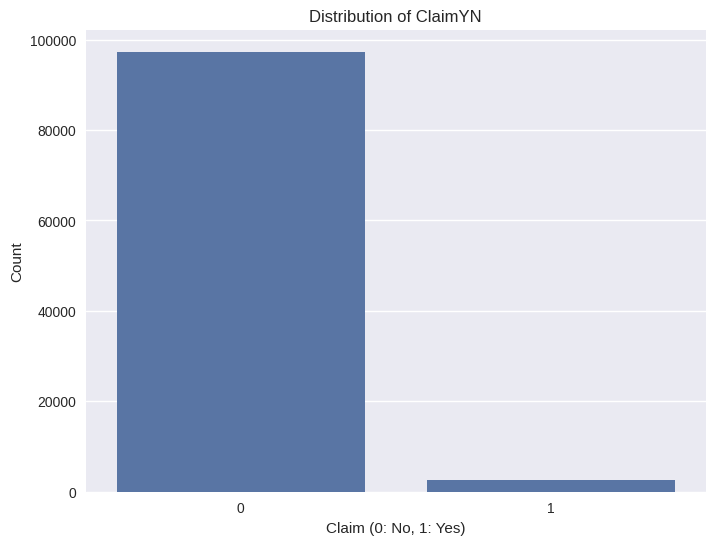

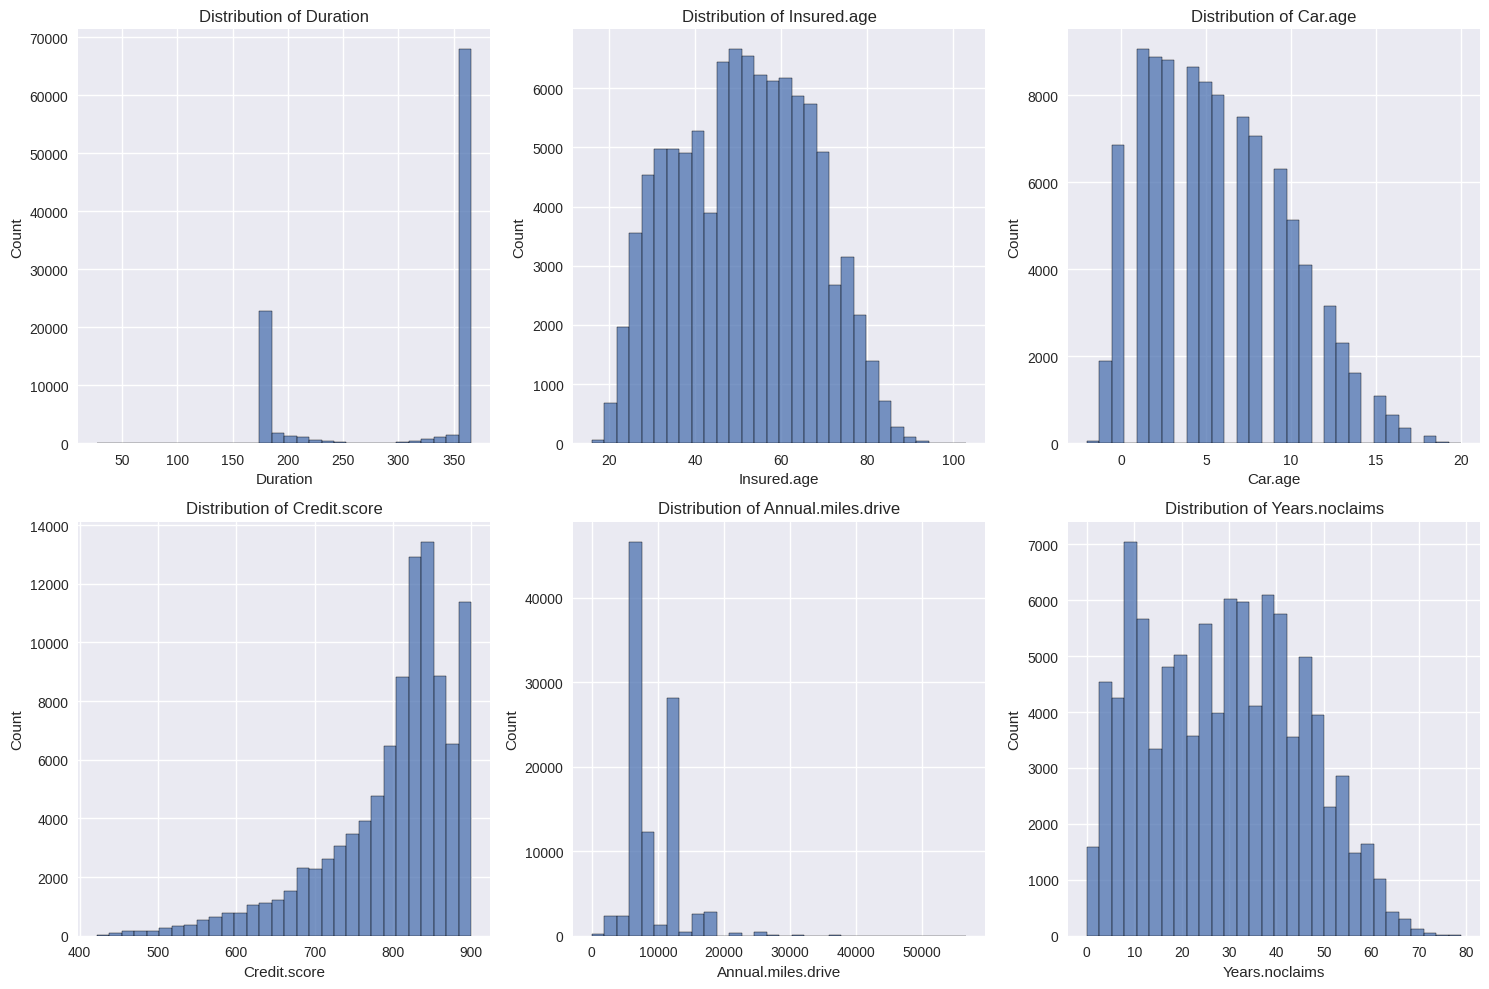

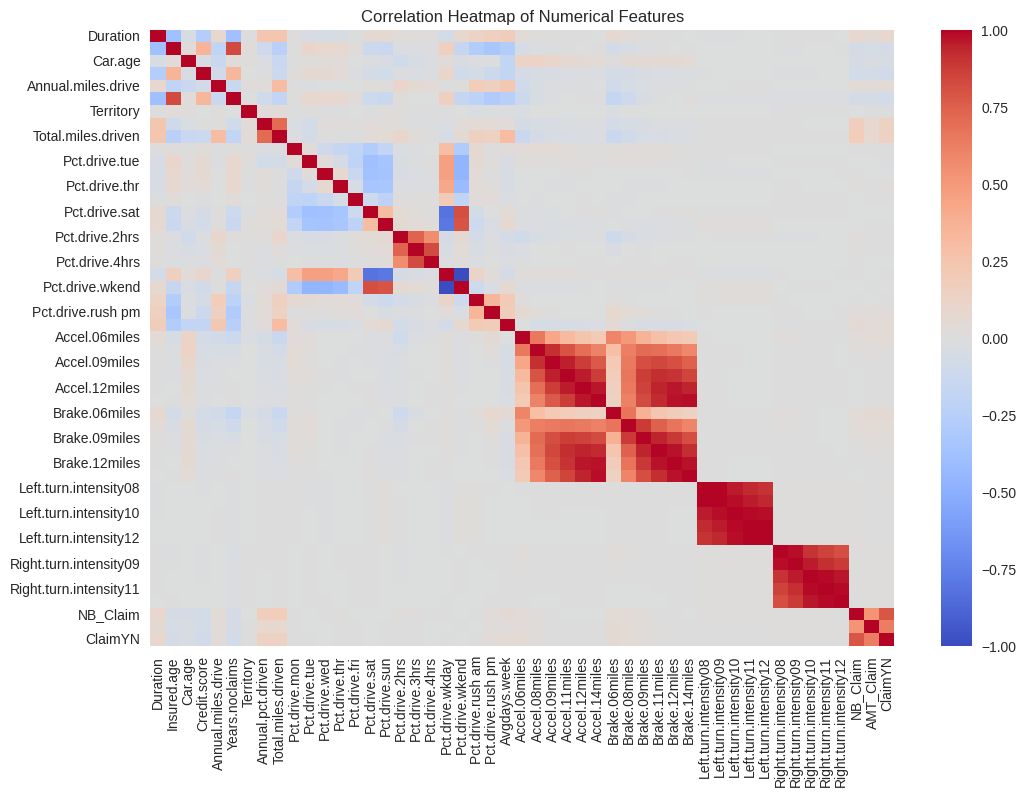

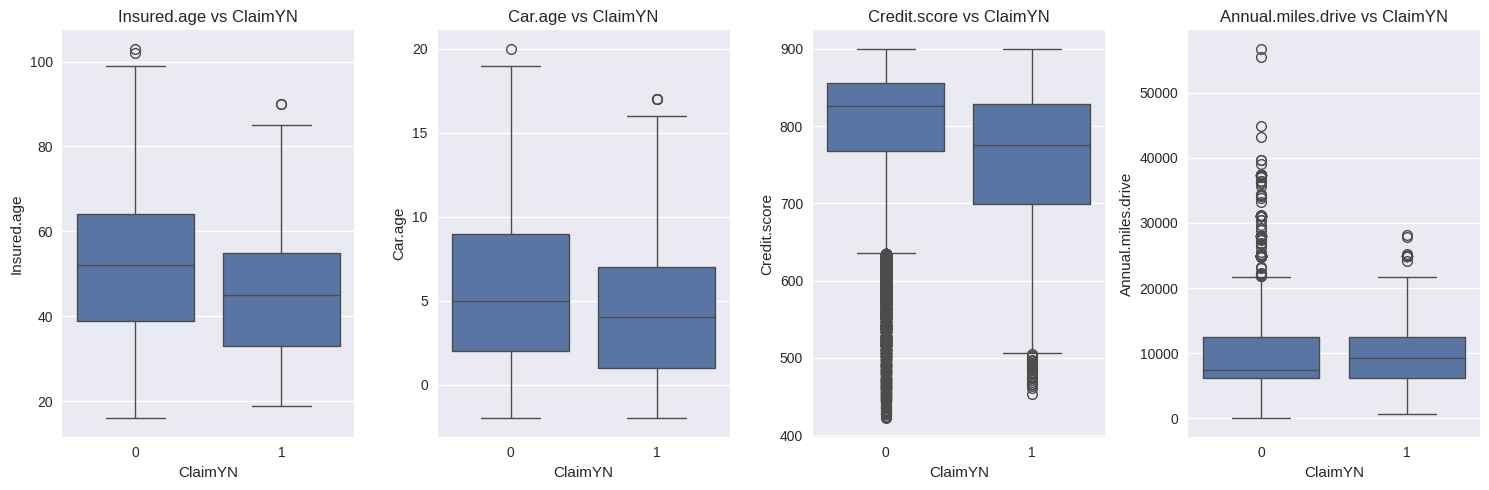

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import optuna
import shap
import lime.lime_tabular
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import tensorflow as tf

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

def load_and_eda(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Basic info
    print("Dataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Create target variable
    df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

    # EDA Visualizations
    # 1. Class Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='ClaimYN', data=df)
    plt.title('Distribution of ClaimYN')
    plt.xlabel('Claim (0: No, 1: Yes)')
    plt.ylabel('Count')
    plt.show()

    # 2. Numerical Features Distribution
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols[:6], 1):  # Show first 6 for brevity
        plt.subplot(2, 3, i)
        sns.histplot(df[col], bins=30)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # 3. Correlation Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numerical_cols].corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

    # 4. Box Plots for Key Features vs ClaimYN
    key_features = ['Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive']
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(key_features, 1):
        plt.subplot(1, 4, i)
        sns.boxplot(x='ClaimYN', y=col, data=df)
        plt.title(f'{col} vs ClaimYN')
    plt.tight_layout()
    plt.show()

    return df

# Usage
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = load_and_eda(file_path)